In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

pd.set_option('display.max_rows', 1000)

In [2]:
df = pd.read_json('Trips-Output.json')

# data cleansing
cleaned_df = df.copy()
cleaned_df = cleaned_df.sort_values(by=['vin', 'start_time'])
cleaned_df = cleaned_df.reset_index()
del cleaned_df['index']

# continous: to decide whether this is a continous event based on 2 cases:
# 1) start and end locations are the same
# 2) end location is equal to the next start location
cleaned_df["continuous_x"] = cleaned_df['start_x_ind'] - cleaned_df['end_x_ind'].shift(1)
cleaned_df["continuous_y"] = cleaned_df['start_y_ind'] - cleaned_df['end_y_ind'].shift(1)
cleaned_df['continuous_x'] = cleaned_df['continuous_x'].fillna(999999999999999999)
cleaned_df['continuous_y'] = cleaned_df['continuous_y'].fillna(999999999999999999)

cleaned_df["continuous"] = np.zeros(len(cleaned_df))
cleaned_df.loc[(cleaned_df['continuous_x'] == 0) & (cleaned_df['continuous_y'] == 0), "continuous"] = 1

del cleaned_df['continuous_x']
del cleaned_df['continuous_y']

# re-format data
start_cols = [
    'vin',
    'start_time',
    'start_x_ind',
    'start_y_ind',
    'start_soc_perc',
    'start_soc_kwh',
    'vehicle_type',
    'continuous'
]

end_cols = [
    'vin',
    'end_time',
    'end_x_ind',
    'end_y_ind',
    'end_soc_perc',
    'end_soc_kwh',
    'vehicle_type',
]

cols_name = [
    'vin',
    'time',
    'x_ind',
    'y_ind',
    'soc_perc',
    'soc_kwh',
    'vehicle_type',
    'continuous',
    'start_engine'
]

start_df =  cleaned_df[start_cols].copy()
start_df['start_engine'] = 1

end_df =  cleaned_df[end_cols].copy()
end_df['continuous'] = 1
end_df['start_engine'] = 0


start_df.columns = cols_name
end_df.columns = cols_name

cleaned_df = pd.concat([start_df, end_df])
cleaned_df = cleaned_df.sort_values(by=['vin', 'time'])
cleaned_df = cleaned_df.reset_index()
del cleaned_df['index']

# add diff cols

cleaned_df['1st_record'] = cleaned_df['vin'].diff()
cleaned_df.loc[0, '1st_record'] = 1

invalid_diff_index = (cleaned_df['1st_record'] == 1) | (cleaned_df['continuous'] == 0)

cleaned_df['perc_diff'] = cleaned_df['soc_perc'].diff()
cleaned_df.loc[invalid_diff_index, 'perc_diff'] = np.nan

cleaned_df['kwh_diff'] = cleaned_df['soc_kwh'].diff()
cleaned_df.loc[invalid_diff_index, 'kwh_diff'] = np.nan

cleaned_df['time_diff'] = cleaned_df['time'].diff()
cleaned_df.loc[invalid_diff_index, 'time_diff'] = np.nan

cleaned_df['xloc_diff'] = cleaned_df['x_ind'].diff()
cleaned_df.loc[invalid_diff_index, 'xloc_diff'] = np.nan

cleaned_df['yloc_diff'] = cleaned_df['y_ind'].diff()
cleaned_df.loc[invalid_diff_index, 'yloc_diff'] = np.nan

cleaned_df['loc'] = list(zip(cleaned_df.x_ind, cleaned_df.y_ind))
cleaned_df['loc_diff'] = list(zip(cleaned_df.xloc_diff, cleaned_df.yloc_diff))

cleaned_df['time_diff(hrs)'] = cleaned_df['time_diff'] / np.timedelta64(1, 'h')
cleaned_df['avg_charging(kwh/hrs)'] = cleaned_df['kwh_diff'] / cleaned_df['time_diff(hrs)']

del cleaned_df['x_ind']
del cleaned_df['y_ind']
del cleaned_df['xloc_diff']
del cleaned_df['yloc_diff']
del cleaned_df['time_diff']

# remove unrealistic data: when perc increases(decreases), kwh should also increases(decreases)
cleaned_df = cleaned_df[((cleaned_df["perc_diff"] > 0) & (cleaned_df["kwh_diff"] > 0)) |
                        ((cleaned_df["perc_diff"] < 0) & (cleaned_df["kwh_diff"] < 0))|
                        ((cleaned_df["perc_diff"] == 0) & (cleaned_df["kwh_diff"] == 0))]

# off road: not on a a trip (only this relevant to find charging stations)
# on road: on a trip (driving)
off_road_df = cleaned_df[cleaned_df['continuous'] == 1][cleaned_df['start_engine'] == 1]
on_road_df = cleaned_df[cleaned_df['continuous'] == 1][cleaned_df['start_engine'] == 0]

In [3]:
# charging stations are based on 2 criteria
# 1) no change in location (not moving) 
# 2) increase in soc_perc
charging_df = off_road_df.copy()
charging_df = charging_df[charging_df['loc_diff']==(0,0)]
charging_df = charging_df[charging_df['perc_diff']>0]

In [4]:
# get more information for further analysis
report = charging_df.groupby(['loc']).agg({'time_diff(hrs)': ['median', 'max', 'sum'],
                                         'perc_diff': ['median'],
                                           'kwh_diff': ['median', 'sum'],
                                         'vehicle_type': pd.Series.nunique,
                                         'avg_charging(kwh/hrs)': ['median','count'],
                                         'vin': pd.Series.nunique}).sort_values(by=('vin', 'nunique'),
                                                                                ascending=True)
report["usage/person"] = report[('avg_charging(kwh/hrs)', 'count')] / report[('vin', 'nunique')]
report = report.reset_index()

In [ ]:
report

In [5]:
# identifying charging stations based on 2 criteria:
# 1) average kwh difference > 1
# 2) average charging speed per hour > 1
cleaned_report = report.copy()
cleaned_report['avg_kwh_diff'] = cleaned_report[('kwh_diff', 'sum')] / cleaned_report[('avg_charging(kwh/hrs)', 'count')]
cleaned_report = cleaned_report[cleaned_report['avg_kwh_diff'] > 1]
cleaned_report = cleaned_report[cleaned_report[('avg_charging(kwh/hrs)', 'median')] > 1]

In [ ]:
cleaned_report

In [6]:
# distinguish between public and private
# private stations based on 2 criteria:
# 1) the occurrence of charging event > 2, otherwise too little information
# 2) charging event per person > 1
private_report = cleaned_report.copy()
private_report = private_report[private_report[('avg_charging(kwh/hrs)', 'count')] > 2]
private_report = private_report[private_report['usage/person'] > 1]

In [ ]:
private_report

(0.0, 100.0)

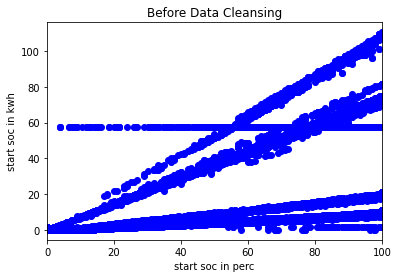

In [7]:
# more information on data cleansing
# before
plt.scatter(df['start_soc_perc'], df['start_soc_kwh'], color="blue")
plt.xlabel("start soc in perc")
plt.ylabel("start soc in kwh")
plt.title('Before Data Cleansing')
plt.xlim(0, 100)

(0.0, 100.0)

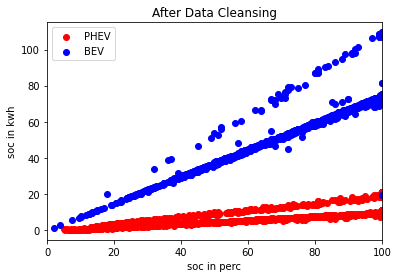

In [8]:
# after (only focus on charging stations one)
vehicle_type_color = {'PHEV': 'red', 'BEV': "blue"}
classes = ['PHEV', 'BEV']
for vt, c in vehicle_type_color.items():
    df_sel = charging_df[charging_df["vehicle_type"]==vt]
    plt.scatter(df_sel['soc_perc'], df_sel['soc_kwh'], color=c)
plt.xlabel("soc in perc")
plt.ylabel("soc in kwh")
plt.title('After Data Cleansing')
plt.legend(labels=classes)
plt.xlim(0, 100)

In [ ]:
# difference between PHEV and BEV statistics
# compare duration of time and charging speed
report2 = charging_df.groupby(['vehicle_type']).agg({'time_diff(hrs)': ['median'],
                                         'perc_diff': ['median'],
                                        'kwh_diff': ['median', 'sum'],
                                         'avg_charging(kwh/hrs)': ['median'],
                                         'vin': pd.Series.nunique}).sort_values(by=('vin', 'nunique'),
                                                                                ascending=True)
report2